<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a>


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions:
<ul>
<li>change the output layer</li>
<li> train the model</li>
<li>  identify  several  misclassified samples</li>
 </ul>
You will take several screenshots of your work and share your notebook.


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

--2024-08-19 11:25:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  11.8MB/s    in 3m 31s  

2024-08-19 11:28:57 (11.8 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [ ]:
!unzip -q Positive_tensors.zip

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2024-08-19 11:31:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  17.9MB/s    in 1m 54s  

2024-08-19 11:33:05 (17.7 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [ ]:
#!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [ ]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.
It is too large to train, therefore, the training: 4000 and testing 1000.

In [ ]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content/"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:4000]
            self.Y=self.Y[0:4000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:31000]
            self.Y=self.Y[30000:31000]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
        #image = Image.open(image)

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [ ]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [ ]:
# Step 1: Load the pre-trained model resnet18
model = models.resnet18(pretrained=True)


# Type your code here

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
# transform
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize(224),
transforms.Normalize(mean,std)])

train_dataset = Dataset(transform=composed, train=True)
validation_data = Dataset(transform=composed)


In [ ]:
train_dataset[0]

(tensor([[[ 0.5985,  0.5237,  0.5237,  ..., -0.5232, -0.1493,  0.2246],
          [ 0.6733,  0.5985,  0.4489,  ..., -0.3736, -0.0745,  0.3742],
          [ 0.7481,  0.6733,  0.5237,  ..., -0.1493,  0.1498,  0.5237],
          ...,
          [ 1.7950,  1.7202,  1.4211,  ...,  0.8976,  0.5985,  0.2246],
          [ 1.7202,  1.7202,  1.4211,  ...,  0.8976,  0.5985,  0.2246],
          [ 1.7202,  1.7202,  1.4211,  ...,  0.8228,  0.5985,  0.2994]],
 
         [[ 1.1468,  1.0687,  1.0687,  ...,  0.2089,  0.5997,  0.9905],
          [ 1.2250,  1.1468,  0.9905,  ...,  0.3652,  0.6779,  1.1468],
          [ 1.3031,  1.2250,  1.0687,  ...,  0.5997,  0.9123,  1.3031],
          ...,
          [ 2.4755,  2.3973,  2.0847,  ...,  1.4594,  1.1468,  0.7560],
          [ 2.3973,  2.3973,  2.0847,  ...,  1.4594,  1.1468,  0.7560],
          [ 2.3973,  2.3973,  2.0847,  ...,  1.3813,  1.1468,  0.8342]],
 
         [[ 1.7953,  1.7178,  1.7178,  ...,  0.4784,  0.8657,  1.2530],
          [ 1.8727,  1.7953,

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [ ]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
  param.requires_grad=False

# Type your code here

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [ ]:
model.fc = nn.Linear(512, 2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function


In [ ]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()
# Type your code here

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=512)
val_loader = DataLoader(validation_data, batch_size=512)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [ ]:
#optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [20]:
n_epochs=5
loss_list=[]
accuracy_list=[]

N_test=len(validation_dataset)
N_train=len(train_dataset)

start_time=time.time()
for epoch in range(n_epochs):
    loss_sublist=[]
    for batch, (x, y) in enumerate(train_loader):

        model.train()
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        z = model(x)

        # calculate loss
        loss=criterion(z,y)
        loss_sublist.append(loss.item())

        # calculate gradients of parameters
        loss.backward()

        # update parameters
        optimizer.step()

        if batch % 2 == 0:
          print(f'step={batch}/{len(train_loader)}, epoch={epoch}/{n_epochs}, loss={loss.item()}')


    loss_list.append(np.mean(loss_sublist))
    correct = 0  # Reset at the start of validation
    total_samples = 0

    with torch.no_grad():
      for x_test, y_test in val_loader:
          # set model to eval
          model.eval()

          #make a prediction
          z = model(x_test)

          #find max
          _,yhat=torch.max(z.data,1)


          #Calculate misclassified  samples in mini-batch
          correct +=(yhat==y_test).sum().item()
          total_samples += y_test.size(0)

          #hint +=(yhat==y_test).sum().item()


    accuracy=correct/total_samples
    accuracy_list.append(accuracy)


print(f"Elapsed time: {time.time() - start_time:.2f} seconds")

step=0/8, epoch=0/5, loss=0.1048203557729721
step=2/8, epoch=0/5, loss=0.10937604308128357
step=4/8, epoch=0/5, loss=0.10417440533638
step=6/8, epoch=0/5, loss=0.10218168795108795
step=0/8, epoch=1/5, loss=0.08936519175767899
step=2/8, epoch=1/5, loss=0.09438713639974594
step=4/8, epoch=1/5, loss=0.09181855618953705
step=6/8, epoch=1/5, loss=0.08869943022727966
step=0/8, epoch=2/5, loss=0.07862072438001633
step=2/8, epoch=2/5, loss=0.08367044478654861
step=4/8, epoch=2/5, loss=0.08266215026378632
step=6/8, epoch=2/5, loss=0.07988505810499191
step=0/8, epoch=3/5, loss=0.07054505497217178
step=2/8, epoch=3/5, loss=0.07564122974872589
step=4/8, epoch=3/5, loss=0.07599985599517822
step=6/8, epoch=3/5, loss=0.07243198156356812
step=0/8, epoch=4/5, loss=0.06426642835140228
step=2/8, epoch=4/5, loss=0.06929295510053635
step=4/8, epoch=4/5, loss=0.0705629289150238
step=6/8, epoch=4/5, loss=0.06693416088819504
Elapsed time: 3962.20 seconds


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [21]:
print(accuracy_list)
print(loss_list)

[0.98925, 0.99, 0.9915, 0.99175, 0.99225]
[0.10359544679522514, 0.08982801251113415, 0.08009805995970964, 0.07263762503862381, 0.06677637016400695]


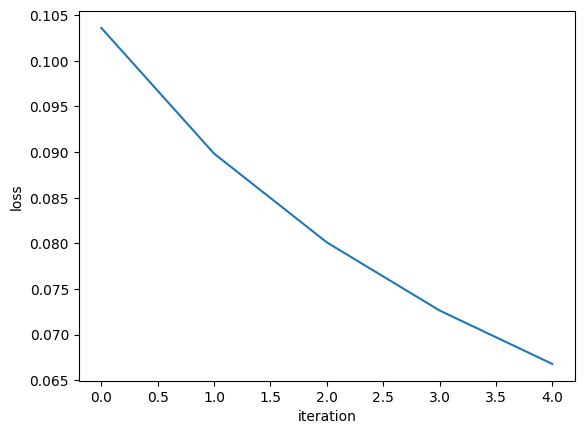

In [22]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2>


<b>Identify the first four misclassified samples using the validation data:</b>


In [51]:
miss_classified = []
model_predicted = []
position = []
ind = 0
with torch.no_grad():
      for x_test, y_test in val_loader:
          # set model to eval
          model.eval()

          #make a prediction
          z = model(x_test)

          #find max
          _,yhat=torch.max(z.data,1)


          #Calculate misclassified  samples in mini-batch
          for i in range(len(yhat)):
            ind += 1 # The current position (index) of the sample
            if len(miss_classified) == 4:
              break
            else:
              if yhat[i]!=y_test[i]:
                miss_classified.append([x_test[i], y_test[i]])
                model_predicted.append(yhat[i])
                position.append(ind)

          if len(miss_classified) == 4:
            break



In [52]:
len(miss_classified)

4

In [53]:
# Incorrect predictions
miss_classified[0][1]

tensor(1)

In [54]:
# The position of the incorrect predictions in the test set
position

[199, 399, 421, 589]

In [55]:
for i in range(4):
  print(f'Sample at position {position[i]} is incorrectly predicted: {miss_classified[0][1].item()}\
  The true label is {model_predicted[i]}')

Sample at position 199 is incorrectly predicted: 1  The true label is 0
Sample at position 399 is incorrectly predicted: 1  The true label is 0
Sample at position 421 is incorrectly predicted: 1  The true label is 0
Sample at position 589 is incorrectly predicted: 1  The true label is 0


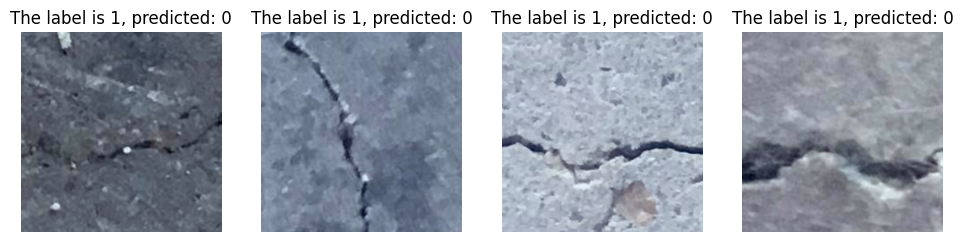

In [57]:
import matplotlib.pyplot as plt
# Plot the batch of 5 images with their predictions
plt.figure(figsize=(15, 15))
for i in range(4):
    img = miss_classified[i][0]
    # Convert PyTorch tensor to NumPy array
    img = img.numpy()
    # Normalize to [0, 1]
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # Change from (C, H, W) to (H, W, C)
    img = np.transpose(img, (1, 2, 0))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)  # Display the image
    plt.title(f'The label is {miss_classified[i][1].item()}, predicted: {model_predicted[i]}')
    plt.axis('off')  # Hide the axes
plt.show()

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01&utm_medium=Exinfluencer&utm_term=10006555"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2>

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
